# Optimization 4

Reflection model

In [1]:
using Distributed
using SharedArrays
addprocs(11)

11-element Array{Int64,1}:
  2
  3
  4
  5
  6
  7
  8
  9
 10
 11
 12

In [2]:
@everywhere include("inverse_prob.jl")

# Background

In [3]:
@eval @everywhere begin
Nx = 101;
Ny = 101;
h = 0.01;

Fs = 500;
dt = 1/Fs
Nt = 1001;
t = range(0, length=Nt, step=dt)

source = source_ricker(5, 0.2, t)
# plot(t,source); title("ricker source")
source_position = zeros(11,2)
for i = 1:11
#     source_position[i,:] = [3,(i-1)*10+1]
    source_position[i,:] = [5, (i-1)*10+1]
end
source = repeat(source, 1, 11)

# receiver_position = zeros(101,2)
# for i = 1:51
# #     receiver_position[i,:] = [1,(i-1)*2+1]
#     receiver_position[i,:] = [1, (i-1)*2+1]
# end
# for i = 52:101
# #     receiver_position[i,:] = [1,(i-1)*2+1]
#     receiver_position[i,:] = [101, (i-51)*2+1]
# end
    
receiver_position = zeros(51,2)
for i = 1:51
#     receiver_position[i,:] = [1,(i-1)*2+1]
    receiver_position[i,:] = [1, (i-1)*2+1]
end

c = ones(Nx, Ny)
rho = ones(Nx, Ny)

c0 = ones(Nx, Ny)
c00 = ones(Nx, Ny)
rho0 = ones(Nx, Ny)
# c0[25:end,:] .= 1.2;
c0[30:50,30:50] .= 1.2
c00[50:70,50:70] .= 1.2

c = imfilter(c00, Kernel.gaussian(20));
    
pml_len = 10
pml_coef=  100
end

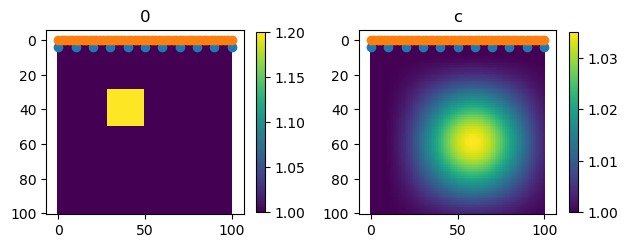

In [4]:
figure; 
subplot(121); imshow(c0); colorbar(shrink=0.4); title("0")
scatter(source_position[:,2].-1, source_position[:,1].-1)
scatter(receiver_position[:,2].-1, receiver_position[:,1].-1)
subplot(122); imshow(c); colorbar(shrink=0.4); title("c")
scatter(source_position[:,2].-1, source_position[:,1].-1)
scatter(receiver_position[:,2].-1, receiver_position[:,1].-1)
tight_layout()

## Build data

In [5]:
@time data, u = multi_solver_parallel(c, rho, Nx, Ny, Nt, h, dt, source, source_position, receiver_position; pml_len=10, pml_coef=100);

@time data0, u0 = multi_solver_parallel(c0, rho0, Nx, Ny, Nt, h, dt, source, source_position, receiver_position; pml_len=10, pml_coef=100);

 22.081220 seconds (7.68 M allocations: 384.971 MiB, 1.73% gc time)
  4.105729 seconds (5.72 k allocations: 251.031 KiB)


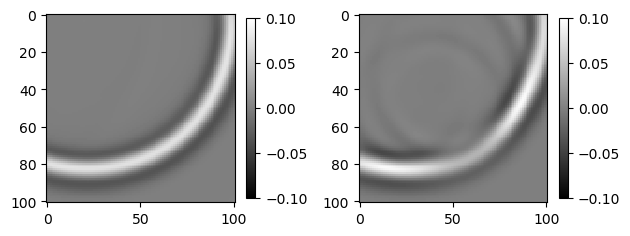

In [6]:
figure;
subplot(121); imshow(u[:,:,500,3],cmap=ColorMap("gray")); colorbar(shrink=0.4); clim(-0.1,0.1)
subplot(122);imshow(u0[:,:,500,3],cmap=ColorMap("gray")); colorbar(shrink=0.4); clim(-0.1,0.1)
tight_layout()

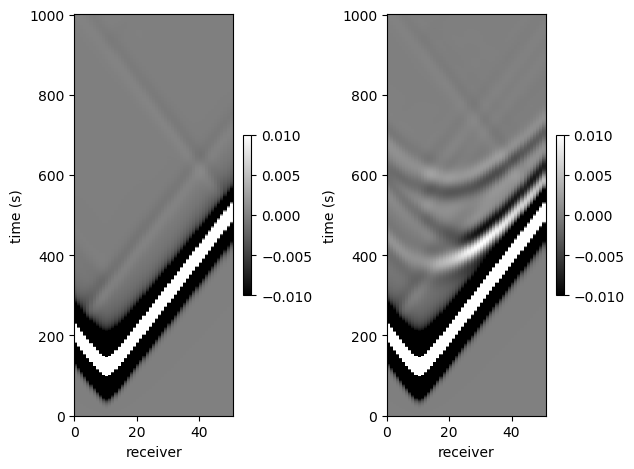

In [7]:
figure;
r_axis = 0:21
subplot(121); pcolor(data[:,:,3],cmap=ColorMap("gray")); colorbar(shrink=0.4); clim([-0.01,0.01])
xlabel("receiver"); ylabel("time (s)")
subplot(122); pcolor(data0[:,:,3],cmap=ColorMap("gray")); colorbar(shrink=0.4); clim([-0.01,0.01])
xlabel("receiver"); ylabel("time (s)")
tight_layout()

In [8]:
# Test gradient
@time gg = grad_l2_parallel(data, u, data0, c, rho, Nx, Ny, Nt, h, dt, source_position, receiver_position; pml_len=10, pml_coef=100);

 16.652943 seconds (7.36 M allocations: 8.719 GiB, 7.51% gc time)


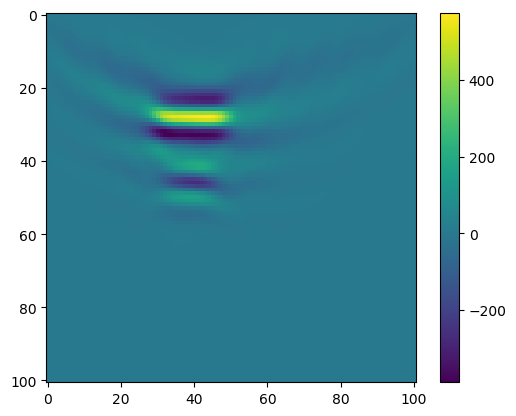

PyObject <matplotlib.colorbar.Colorbar object at 0x7efc2dc37240>

In [9]:
imshow(gg); colorbar()

## Test Gradient descent

In [10]:
obj_fn_gd(x) = obj_fn_parallel(data0, x, rho, Nx, Ny, Nt, h, dt, source, source_position, receiver_position; pml_len=10, pml_coef=100)

obj_fn_gd (generic function with 1 method)

In [11]:
c_gd, error_gd = gradient_descent(obj_fn_gd, c, 1e-5, 10, 1, 1.2; rho=0.8, c=1e-9, maxSearchTime=5);

Main iteration: 1
Start line search. fk: 9.11398e-04
    alpha: 1.00000e-05    fk1: 8.99189e-04    fk-c*alpha*gradk^2: 9.11068e-04
Line search succeed. Search time: 0.
----------------------------------------------------------------
Main iteration: 2
Start line search. fk: 8.99189e-04
    alpha: 1.00000e-05    fk1: 8.86783e-04    fk-c*alpha*gradk^2: 8.98867e-04
Line search succeed. Search time: 0.
----------------------------------------------------------------
Main iteration: 3
Start line search. fk: 8.86783e-04
    alpha: 1.00000e-05    fk1: 8.71854e-04    fk-c*alpha*gradk^2: 8.86469e-04
Line search succeed. Search time: 0.
----------------------------------------------------------------
Main iteration: 4
Start line search. fk: 8.71854e-04
    alpha: 1.00000e-05    fk1: 8.56303e-04    fk-c*alpha*gradk^2: 8.71549e-04
Line search succeed. Search time: 0.
----------------------------------------------------------------
Main iteration: 5
Start line search. fk: 8.56303e-04
    alpha: 1.00

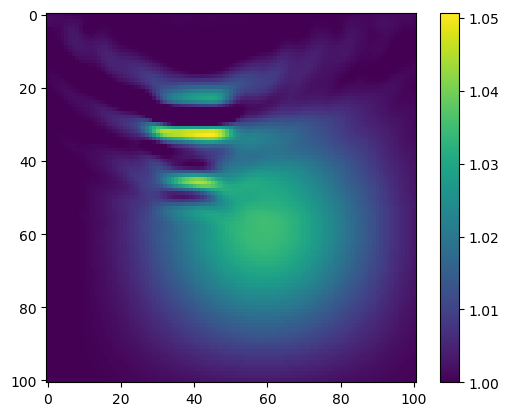

In [12]:
imshow(reshape(c_gd,Nx,Ny)); colorbar();

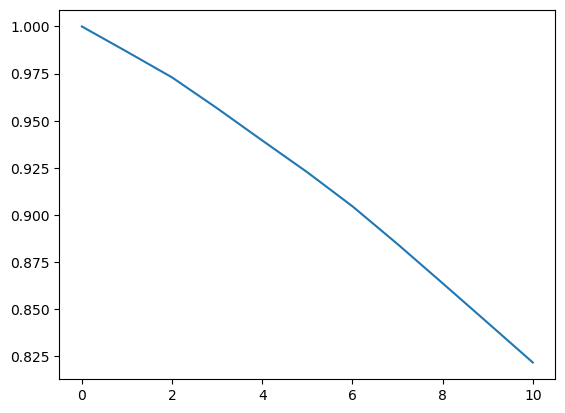

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7efcd261ac50>

In [13]:
eee = error_gd ./ maximum(error_gd)
plot(eee)

# Test with Sinkhorn

In [14]:
@everywhere include("inverse_prob.jl")

In [15]:
@time aa, dd = adj_source_sinkhorn_parallel(data, data0; lambda=10, numItermax=2, stopThr = 1e-7, verbose=false);
dd

 19.694397 seconds (2.36 M allocations: 133.723 MiB, 0.44% gc time)


7.7712095901373175

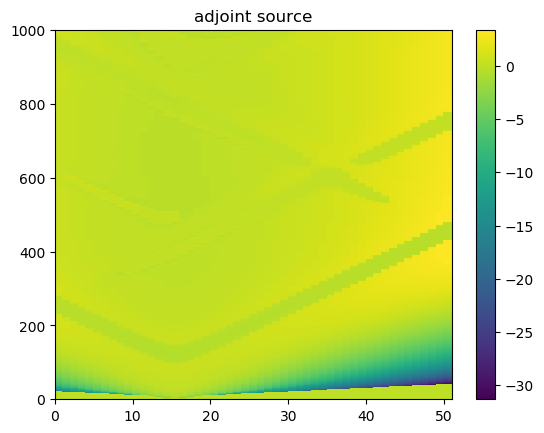

PyObject Text(0.5, 1, 'adjoint source')

In [16]:
pcolor(aa[:,:,4]); colorbar(); title("adjoint source")

In [17]:
@time ggg, dd =  grad_sinkhorn_parallel(data, u, data0, c, rho, Nx, Ny, Nt, h, dt, source_position, receiver_position; pml_len=10, pml_coef=100, lambda=1000, numItermax=5, stopThr = 1e-6);

 32.701841 seconds (1.22 M allocations: 8.435 GiB, 3.82% gc time)


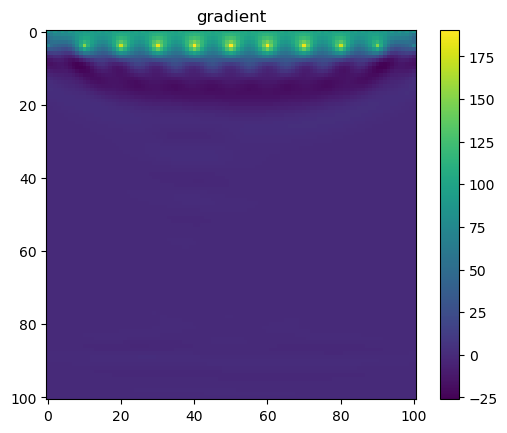

0.2642035784775796

In [18]:
imshow(ggg); colorbar(); title("gradient")
dd

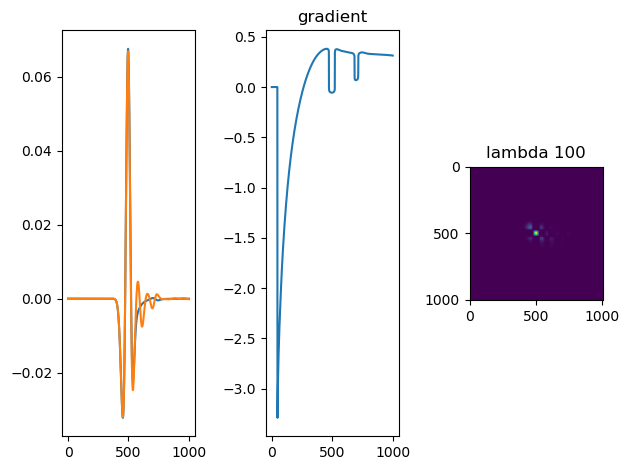

In [19]:
f1 = data[:,50,3]
f2 = data0[:,50,3]

T,a,d = sinkhorn_signal_1d(f1, f2, M; lambda=100, numItermax = 1000, stopThr = 1e-6, verbose=false)

figure;
subplot(131); plot(f1); plot(f2)
subplot(132); plot(a); title("gradient")
subplot(133); imshow(T); title("lambda 100")
tight_layout()


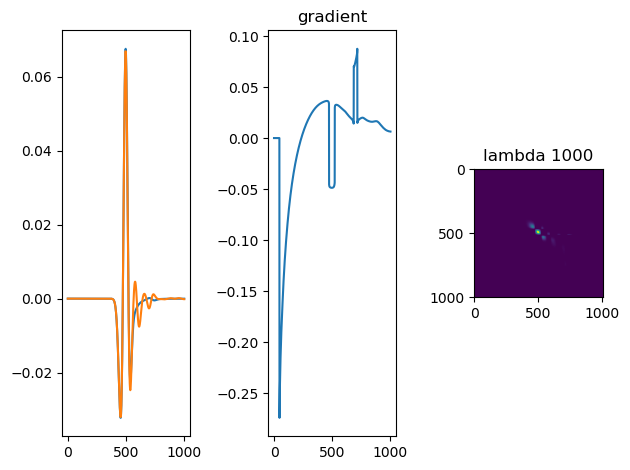

In [20]:
T,a,d = sinkhorn_signal_1d(f1, f2, M; lambda=1000, numItermax = 1000, stopThr = 1e-6, verbose=false)

figure;
subplot(131); plot(f1); plot(f2)
subplot(132); plot(a); title("gradient")
subplot(133); imshow(T); title("lambda 1000")
tight_layout()

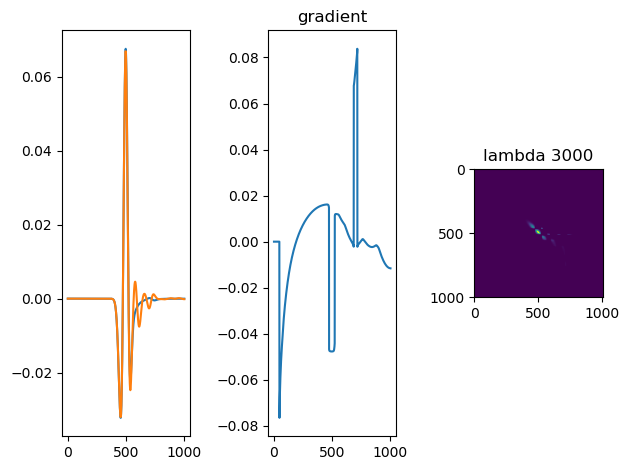

In [21]:
T,a,d = sinkhorn_signal_1d(f1, f2, M; lambda=3000, numItermax = 1000, stopThr = 1e-6, verbose=false)

figure;
subplot(131); plot(f1); plot(f2)
subplot(132); plot(a); title("gradient")
subplot(133); imshow(T); title("lambda 3000")
tight_layout()

In [22]:
obj_fn_gd(x) = obj_fn_sinkhorn_parallel(data0, x, rho, Nx, Ny, Nt, h, dt, source, source_position, receiver_position; pml_len=10, pml_coef=100, lambda=1000, numItermax=100, stopThr = 1e-6)

obj_fn_gd (generic function with 1 method)

In [23]:
c_sink, error_sink = gradient_descent(obj_fn_gd, c, 1e-5, 10, 1, 1.2; rho=0.5, c=1e-9, maxSearchTime=5);

Main iteration: 1
Start line search. fk: 2.64114e-01
    alpha: 1.00000e-05    fk1: 2.64114e-01    fk-c*alpha*gradk^2: 2.64114e-01
Line search succeed. Search time: 0.
----------------------------------------------------------------
Main iteration: 2
Start line search. fk: 2.64114e-01
    alpha: 1.00000e-05    fk1: 2.64114e-01    fk-c*alpha*gradk^2: 2.64114e-01
    alpha: 5.00000e-06    fk1: 2.64114e-01    fk-c*alpha*gradk^2: 2.64114e-01
    alpha: 2.50000e-06    fk1: 2.64114e-01    fk-c*alpha*gradk^2: 2.64114e-01
    alpha: 1.25000e-06    fk1: 2.64114e-01    fk-c*alpha*gradk^2: 2.64114e-01
    alpha: 6.25000e-07    fk1: 2.64114e-01    fk-c*alpha*gradk^2: 2.64114e-01
    alpha: 3.12500e-07    fk1: 2.64114e-01    fk-c*alpha*gradk^2: 2.64114e-01
Line search failed. Search time: 5. Try to decrease search coef c.
----------------------------------------------------------------
Line search Failed. Try decrease line search coef alpha. Interupt.
-----------------------------------------------

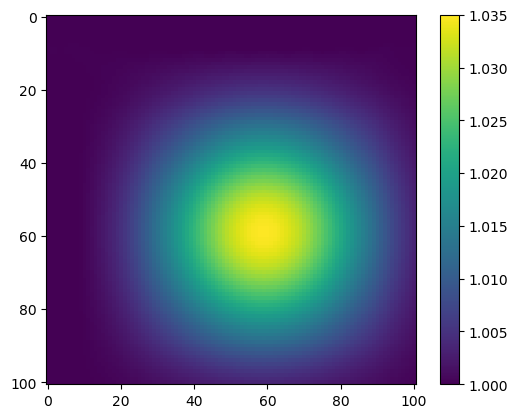

In [24]:
imshow(reshape(c_sink,Nx,Ny)); colorbar();

In [25]:
# plot(eee)
# plot(error_sink ./ maximum(error_sink))